# 演習・Twitterのテキスト分類問題

実データを用いて機械学習を用いた分類問題を実践例として、Twitter投稿データの分類問題を考えます。

（ここでは、2020年に収集したデータを用います）


国内政治家アカウントのうち、データ収集時に最もフォロワー数がいる2人（橋下徹 @hashimoto_lo
安倍晋三 @AbeShinzo）のツイートをそれぞれどのユーザーの発信によるものか分類してみましょう。

In [1]:
import pandas as pd
import pickle
import numpy as np
from matplotlib import pyplot as plt
import japanize_matplotlib
%matplotlib inline
pd.set_option('display.max_columns', 100)

In [2]:
dfs = []
for user in ['hashimoto_lo','AbeShinzo']:
    with open('./data/tweets_{}.pkl'.format(user), 'rb') as f:
        tmp = pickle.load(f)
        dfs.append(tmp)

In [3]:
df = pd.concat(dfs)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5284 entries, 0 to 2067
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   contributors               0 non-null      object 
 1   coordinates                0 non-null      object 
 2   created_at                 5284 non-null   object 
 3   entities                   5284 non-null   object 
 4   extended_entities          674 non-null    object 
 5   favorite_count             5284 non-null   int64  
 6   favorited                  5284 non-null   bool   
 7   geo                        0 non-null      object 
 8   id                         5284 non-null   int64  
 9   id_str                     5284 non-null   object 
 10  in_reply_to_screen_name    812 non-null    object 
 11  in_reply_to_status_id      810 non-null    float64
 12  in_reply_to_status_id_str  810 non-null    object 
 13  in_reply_to_user_id        812 non-null    float64
 1

In [5]:
df.head(5)

contributors coordinates                      created_at  \
0         None        None  Sun Aug 02 22:39:43 +0000 2020   
1         None        None  Sat Aug 01 15:49:14 +0000 2020   
2         None        None  Sat Aug 01 13:45:07 +0000 2020   
3         None        None  Sat Aug 01 13:45:06 +0000 2020   
4         None        None  Sat Aug 01 12:00:34 +0000 2020   

                                            entities extended_entities  \
0  {'hashtags': [], 'symbols': [], 'user_mentions...               NaN   
1  {'hashtags': [{'text': '日曜報道THEPRIME', 'indice...               NaN   
2  {'hashtags': [], 'symbols': [], 'user_mentions...               NaN   
3  {'hashtags': [], 'symbols': [], 'user_mentions...               NaN   
4  {'hashtags': [], 'symbols': [], 'user_mentions...               NaN   

   favorite_count  favorited   geo                   id               id_str  \
0             399      False  None  1290054702210531329  1290054702210531329   
1               0      False  None  1289589012785586176  1289589012785586176   
2            1693      False  None  1289557775266136064  1289557775266136064   
3            1341      False  None  1289557773630414850  1289557773630414850   
4             749      False  None  1289531464892088320  1289531464892088320   

  in_reply_to_screen_name  in_reply_to_status_id in_reply_to_status_id_str  \
0                    None                    NaN                      None   
1                    None                    NaN                      None   
2            hashimoto_lo           1.289558e+18       1289557773630414850   
3                    None                    NaN                      None   
4                    None                    NaN                      None   

   in_reply_to_user_id in_reply_to_user_id_str  is_quote_status lang place  \
0                  NaN                    None            False   ja  None   
1                  NaN                    None            False   ja  None   
2          245677083.0               245677083            False   ja  None   
3                  NaN                    None             True   ja  None   
4                  NaN                    None            False   ja  None   

  possibly_sensitive                                      quoted_status  \
0              False                                                NaN   
1                NaN                                                NaN   
2                NaN                                                NaN   
3              False  {'created_at': 'Sat Aug 01 07:14:22 +0000 2020...   
4              False                                                NaN   

   quoted_status_id quoted_status_id_str  retweet_count  retweeted  \
0               NaN                  NaN             44      False   
1               NaN                  NaN             98      False   
2               NaN                  NaN            189      False   
3      1.289459e+18  1289459440555450369            131      False   
4               NaN                  NaN             67      False   

                                    retweeted_status  \
0                                                NaN   
1  {'created_at': 'Sat Aug 01 15:14:22 +0000 2020...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                              source  \
0  <a href="http://twitter.com/download/android" ...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="https://abema.tv" rel="nofollow">ABEM...   

                                                text  truncated  \
0  （スタッフよりお知らせ）本日13:55より生放送「情報ライブ　ミヤネ屋」（読売テレビ）に、橋...      False   
1  RT @THEPRIME_CX: 今日の #日曜報道THEPRIME は...【感染列島８月...      False   
2  評論家には政治はできません。た

In [6]:
df['user_name'] = df['user'].apply(lambda x: x['name'])

In [7]:
df = df.drop_duplicates(['id'])

In [8]:
df['user_screen_name'] = df['user'].apply(lambda x: x['screen_name'])

## 全期間におけるユーザー別ツイート数

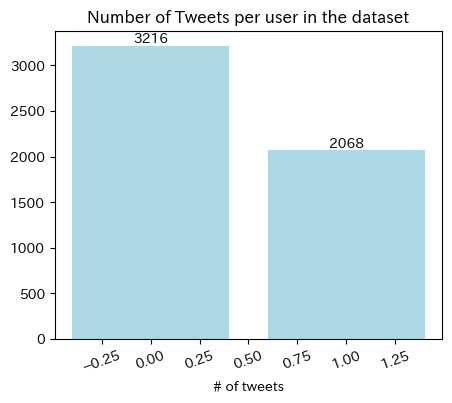

In [9]:
fig, ax = plt.subplots(1,1,figsize= (5,4))
N_tweets_users = df['user_screen_name'].value_counts().to_frame().reset_index().sort_values(by = 'user_screen_name', ascending=False)
bars = plt.bar(N_tweets_users.index, N_tweets_users['count'], color = 'lightblue')
ax.bar_label(bars)
plt.title('Number of Tweets per user in the dataset')
plt.xlabel('# of tweets')
plt.xticks(rotation=20)
plt.show()

分析対象はRetweetでは無いオリジナルのTweetsのみとする

In [10]:
df = df[df['retweeted_status'].isnull()]

In [11]:
print(df.shape)

(4244, 31)


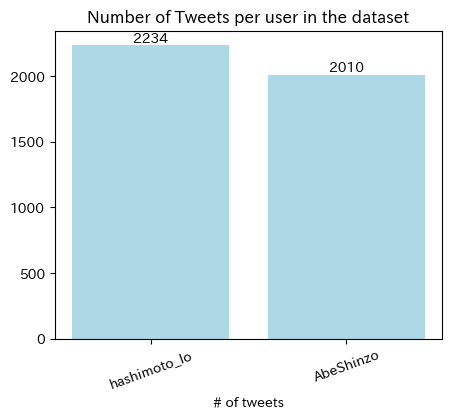

In [12]:
fig, ax = plt.subplots(1,1,figsize= (5,4))
N_tweets_users = df['user_screen_name'].value_counts().to_frame().sort_values(by = 'user_screen_name', ascending=False)
bars = plt.bar(N_tweets_users.index, N_tweets_users['count'], color = 'lightblue')
ax.bar_label(bars)
plt.title('Number of Tweets per user in the dataset')
plt.xlabel('# of tweets')
plt.xticks(rotation=20)
plt.show()

## 年別のツイート数

In [13]:
df['created_at'] = pd.to_datetime(df['created_at'])
df['date'] = df['created_at'].dt.date
df['year'] = df['created_at'].dt.year
df['time'] = df['created_at'].dt.time

/var/folders/z5/0lnyp_m54dqc1xkz22ncbj2h0000gn/T/ipykernel_44838/1336334527.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'])


In [14]:
df.head(1)

contributors coordinates                created_at  \
0         None        None 2020-08-02 22:39:43+00:00   

                                            entities extended_entities  \
0  {'hashtags': [], 'symbols': [], 'user_mentions...               NaN   

   favorite_count  favorited   geo                   id               id_str  \
0             399      False  None  1290054702210531329  1290054702210531329   

  in_reply_to_screen_name  in_reply_to_status_id in_reply_to_status_id_str  \
0                    None                    NaN                      None   

   in_reply_to_user_id in_reply_to_user_id_str  is_quote_status lang place  \
0                  NaN                    None            False   ja  None   

  possibly_sensitive quoted_status  quoted_status_id quoted_status_id_str  \
0              False           NaN               NaN                  NaN   

   retweet_count  retweeted retweeted_status  \
0             44      False              NaN   

                                              source  \
0  <a href="http://twitter.com/download/android" ...   

                                                text  truncated  \
0  （スタッフよりお知らせ）本日13:55より生放送「情報ライブ　ミヤネ屋」（読売テレビ）に、橋...      False   

                                                user user_name  \
0  {'id': 245677083, 'id_str': '245677083', 'name...       橋下徹   

  user_screen_name        date  year      time  
0     hashimoto_lo  2020-08-02  2020  22:39:43

In [15]:
pd.crosstab(df['user_name'],df['year'])

year       2012  2013  2014  2015  2016  2017  2018  2019  2020
user_name                                                      
安倍晋三        336   315   318   168    62    73   247   288   203
橋下徹           0     0     0     0     0     0    21  1212  1001

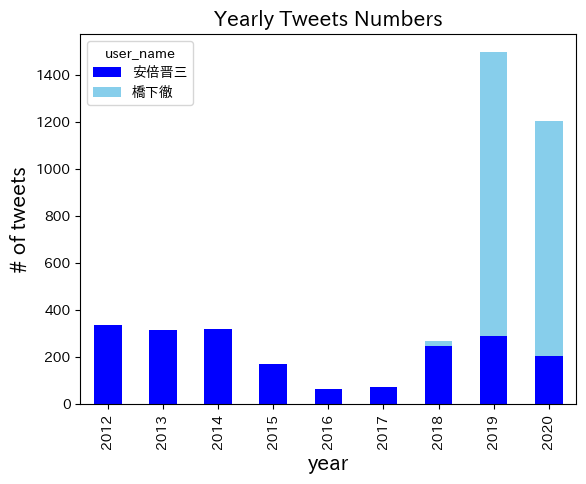

In [16]:
pd.crosstab(df['user_name'],df['year']).T.plot.bar(stacked=True, color=['blue','skyblue'])
plt.title('Yearly Tweets Numbers', fontsize=15)
plt.xlabel('year', fontsize=15)
plt.ylabel('# of tweets', fontsize=15)
plt.show()

## ユーザー別のLikesのヒストグラム

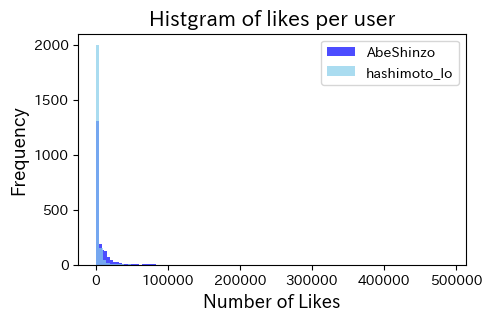

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(5,3))

for i, arr in enumerate(df.groupby(['user_screen_name'])['favorite_count']):
    ax.hist(arr[1], bins = 100, 
            color=['blue','skyblue'][i], alpha = .7, label = arr[0])
plt.legend()
plt.title('Histgram of likes per user', fontsize=15)
plt.ylabel('Frequency', fontsize=13)
plt.xlabel('Number of Likes', fontsize=13)
plt.show()

上の図では少しわかりにくいので、対数変換値をプロット

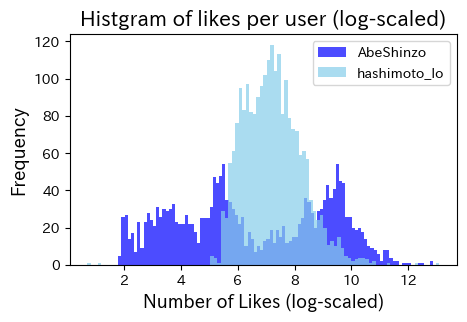

In [18]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
for i, arr in enumerate(df.groupby(['user_screen_name'])['favorite_count']):
    ax.hist(arr[1].apply(lambda x: np.log(x)), bins = 100, 
            color=['blue','skyblue'][i], alpha = .7, label = arr[0])
plt.legend()
plt.title('Histgram of likes per user (log-scaled)', fontsize=15)
plt.ylabel('Frequency', fontsize=13)
plt.xlabel('Number of Likes (log-scaled)', fontsize=13)
plt.show()

## ユーザー別のRetweetされた数のヒストグラム

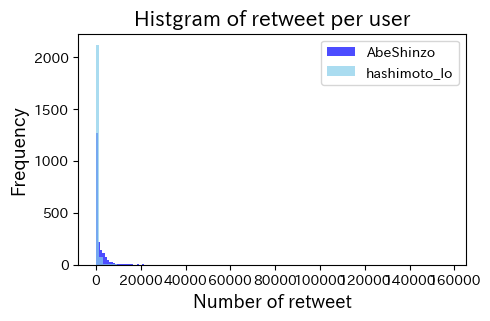

In [19]:
fig, ax = plt.subplots(1,1, figsize=(5,3))

for i, arr in enumerate(df.groupby(['user_screen_name'])['retweet_count']):
    ax.hist(arr[1], bins = 100, 
            color=['blue','skyblue'][i], alpha = .7, label = arr[0])
plt.legend()
plt.title('Histgram of retweet per user', fontsize=15)
plt.ylabel('Frequency', fontsize=13)
plt.xlabel('Number of retweet', fontsize=13)
plt.show()

上の図では少しわかりにくいので、対数変換値をプロット

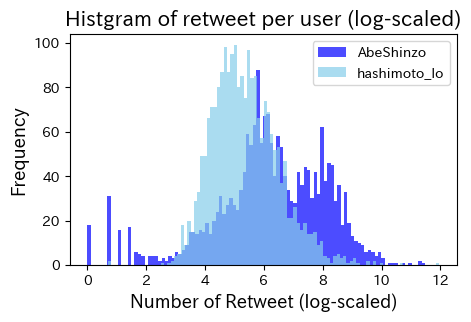

In [20]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
for i, arr in enumerate(df.groupby(['user_screen_name'])['retweet_count']):
    ax.hist(arr[1].apply(lambda x: np.log(1+x)), bins = 100, 
            color=['blue','skyblue'][i], alpha = .7, label = arr[0])
plt.legend()
plt.title('Histgram of retweet per user (log-scaled)', fontsize=15)
plt.ylabel('Frequency', fontsize=13)
plt.xlabel('Number of Retweet (log-scaled)', fontsize=13)
plt.show()

## 日本語の正規化（表記ゆれの是正）と形態素解析を行う

### 正規化
1. 正規化を自動で実施してくれるパッケージをインストール。Terminal or Anaconda Prompt で　`pip install neologdn`
2. `import nelogdn` `neologdn.normalize()` で正規化　

3. Regular ExpressionでテキストからURLを除外する

### 形態素解析
1. `pip install janome`


In [30]:
from janome.tokenizer import Tokenizer
import neologdn
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import sklearn as sk
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import itertools, random


正規化

In [22]:
df.loc[:,'standarized_text'] = df['text'].apply(lambda x: neologdn.normalize(x))

In [23]:
pat = re.compile(r'https?://\S+')
df.loc[:, 'standarized_text'] = df['standarized_text'].apply(lambda x: re.sub(pat, '', x))

In [32]:
# neologd_tagger = MeCab.Tagger('-Ochasen -d /opt/homebrew/lib/mecab/dic/mecab-ipadic-neologd')
t = Tokenizer()
for token in t.tokenize('庭には二羽鶏がいる'):
    print(token)

庭	名詞,一般,*,*,*,*,庭,ニワ,ニワ
に	助詞,格助詞,一般,*,*,*,に,ニ,ニ
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
二	名詞,数,*,*,*,*,二,ニ,ニ
羽	名詞,接尾,助数詞,*,*,*,羽,ワ,ワ
鶏	名詞,一般,*,*,*,*,鶏,ニワトリ,ニワトリ
が	助詞,格助詞,一般,*,*,*,が,ガ,ガ
いる	動詞,自立,*,*,一段,基本形,いる,イル,イル


In [100]:
pat = re.compile('━|\-|\.|\,|[━!-)+,-\./:-@[-`{-~]|^[0-9０-９]+$|^\*$|http|www|html|jp|com|^[a-zA-Z]+$|する|こと|いる|ます')

def tokenize(cell):
    tokens = []
    t = Tokenizer()
    tokenized = t.tokenize(str(cell))
    for node in tokenized:
        node_element = str(node).split(',')
        token = node_element[-3]
        part = ""
        if len(node_element[0].split('\t'))>1:
            part =  node_element[0].split('\t')[1]
        if part in ('名詞','形容詞'): #'動詞',,'感動詞'
            if not pat.match(token) !=None:
                tokens.append(token)

    return tokens

In [101]:
tokenize('これはサンプルテキストです。')

['これ', 'サンプル', 'テキスト']

In [102]:
# Tf-idfを用いる場合
# vectorizer = TfidfVectorizer(analyzer=tokenize)
vectorizer = CountVectorizer(analyzer=tokenize,min_df=20,max_df=.9)
text = vectorizer.fit_transform(df['standarized_text'])

In [103]:
text.shape, df[['user_screen_name']].values.shape

((4244, 690), (4244, 1))

In [104]:
X = pd.DataFrame(text.toarray(), index= df['user_screen_name'],columns = vectorizer.get_feature_names_out())
# もし`get_feature_names_out`でエラーが出たら次のラインで試してください。
# X = pd.DataFrame(text.toarray(), index= df['user_screen_name'],columns = vectorizer.get_feature_names())
X.sample(2)

➡  》#  あと  いい  いっぱい  うち  おかしい  お昼  お知らせ  お祈り  お金  お願い  ここ  \
user_screen_name                                                              
AbeShinzo         0   0   0   0     0   0     0   0     0    0   0    0   0   
AbeShinzo         0   0   0   0     0   0     0   0     0    0   0    0   0   

                  こちら  これ  ご覧  さ  さん  すべて  そう  そこ  その後  それ  たくさん  たち  ため  づくり  \
user_screen_name                                                                
AbeShinzo           0   0   0  0   0    0   0   0    0   0     0   0   0    0   
AbeShinzo           0   0   0  0   0    0   0   0    0   0     0   0   0    0   

                  とき  ところ  ない  の  はじめ  はず  ぶり  まま  みなさま  もと  もの  やり方  よい  よう  \
user_screen_name                                                               
AbeShinzo          0    0   0  0    0   0   0   0     0   0   0    0   0   0   
AbeShinzo          0    0   0  0    0   0   0   0     0   0   0    0   0   0   

                  ら  わけ  ん  アジア  アップ  イベント  インタビュー  インテリ  インド  ...  負担  財政  \
user_screen_name                                               ...           
AbeShinzo         0   0  0    0    0     0       0     0    0  ...   0   0   
AbeShinzo         0   0  0    0    0     0       0     0    0  ...   0   0   

                  責任  貴殿  費  賛成  軽症  通常  連中  連携  週間  道  違い  選  選択  選挙  避難  邦人  \
user_screen_name                                                                
AbeShinzo          0   0  0   0   0   0   0   0   0  0   0  0   0   0   0   0   
AbeShinzo          0   0  0   0   0   0   0   0   0  0   0  0   0   0   0   0   

                  部  都  重症  重要  野党  金  長  開催  間  間違い  関係  関西  関西テレビ  閣僚  防止  \
user_screen_name                                                              
AbeShinzo         0  0   0   0   0  0  0   0  0    0   0   0      0   0   0   
AbeShinzo         0  0   0   0   0  0  0   0  0    0   0   0      0   0   0   

                  防衛  限り  陛下  際  雇用  雑誌  靖国  非常  韓  韓国  頃  首相  首脳  駅  駅前  高い  \
user_screen_name                                                               
AbeShinzo          0   0   0  0   0   0   0   0  0   0  0   0   0  0   0   0   
AbeShinzo          0   0   0  0   0   0   0   0  0   0  0   0   0  0   1   0   

                  高齢  
user_screen_name      
AbeShinzo          0  
AbeShinzo          0  

[2 rows x 690 columns]

In [105]:
cat = pd.Categorical(df['user_screen_name'])
y = cat.codes
print(cat.categories)
y

Index(['AbeShinzo', 'hashimoto_lo'], dtype='object')


array([1, 1, 1, ..., 0, 0, 0], dtype=int8)

In [106]:
X.shape, df.shape

((4244, 690), (4244, 35))

In [107]:
df = df[['created_at','user_name', 'user_screen_name', 'favorite_count','retweet_count',
    'retweeted_status','text','standarized_text','extended_entities']].reset_index(drop=True).merge(X.reset_index(drop=True),
                                left_index=True, right_index=True)

In [108]:
df.head(2)

created_at user_name user_screen_name  favorite_count  \
0 2020-08-02 22:39:43+00:00       橋下徹     hashimoto_lo             399   
1 2020-08-01 13:45:07+00:00       橋下徹     hashimoto_lo            1693   

   retweet_count retweeted_status  \
0             44              NaN   
1            189              NaN   

                                                text  \
0  （スタッフよりお知らせ）本日13:55より生放送「情報ライブ　ミヤネ屋」（読売テレビ）に、橋...   
1  評論家には政治はできません。ただうまくメッセージを出せない政治家も多いでしょう。政治に評論家...   

                                    standarized_text extended_entities  ➡  》#  \
0  (スタッフよりお知らせ)本日13:55より生放送「情報ライブミヤネ屋」(読売テレビ)に、橋下...               NaN  0   0   
1  評論家には政治はできません。ただうまくメッセージを出せない政治家も多いでしょう。政治に評論家...               NaN  0   0   

   あと  いい  いっぱい  うち  おかしい  お昼  お知らせ  お祈り  お金  お願い  ここ  こちら  これ  ご覧  さ  さん  \
0   0   0     0   0     0   0     1    0   0    0   0    0   0   1  0   0   
1   0   0     0   0     0   0     0    0   0    0   0    0   0   0  0   0   

   すべて  そう  そこ  その後  それ  たくさん  たち  ため  づくり  とき  ところ  ない  の  はじめ  はず  ぶり  まま  \
0    0   0   0    0   0     0   0   0    0   0    0   0  0    0   0   0   0   
1    0   0   0    0   0     0   0   0    0   0    0   0  0    0   0   0   0   

   みなさま  もと  もの  やり方  よい  よう  ...  負担  財政  責任  貴殿  費  賛成  軽症  通常  連中  連携  週間  \
0     0   0   0    0   0   0  ...   0   0   0   0  0   0   0   0   0   0   0   
1     0   0   0    0   0   0  ...   0   0   0   0  0   0   0   0   0   0   0   

   道  違い  選  選択  選挙  避難  邦人  部  都  重症  重要  野党  金  長  開催  間  間違い  関係  関西  \
0  0   0  0   0   0   0   0  0  0   0   0   0  0  0   0  0    0   0   0   
1  0   0  0   0   0   0   0  0  0   0   0   0  0  0   0  0    0   0   0   

   関西テレビ  閣僚  防止  防衛  限り  陛下  際  雇用  雑誌  靖国  非常  韓  韓国  頃  首相  首脳  駅  駅前  高い  \
0      0   0   0   0   0   0  0   0   0   0   0  0   0  0   0   0  0   0   0   
1      0   0   0   0   0   0  0   0   0   0   0  0   0  0   0   0  0   0   0   

   高齢  
0   0  
1   0  

[2 rows x 699 columns]

### 訓練データとテストデータをに分ける

In [110]:
# Split our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Logistic Regression

In [111]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)

#### Modelの精度

In [112]:
print(classification_report(y_test, y_pred, target_names=cat.categories))

              precision    recall  f1-score   support

   AbeShinzo       0.92      0.98      0.95       486
hashimoto_lo       0.98      0.93      0.95       575

    accuracy                           0.95      1061
   macro avg       0.95      0.95      0.95      1061
weighted avg       0.95      0.95      0.95      1061



#### Confusion Matirx

In [113]:
print(metrics.confusion_matrix(y_test, y_pred))

[[475  11]
 [ 41 534]]


In [114]:
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), columns = cat.categories,
             index = cat.categories)

AbeShinzo  hashimoto_lo
AbeShinzo           475            11
hashimoto_lo         41           534

#### ROC Curve

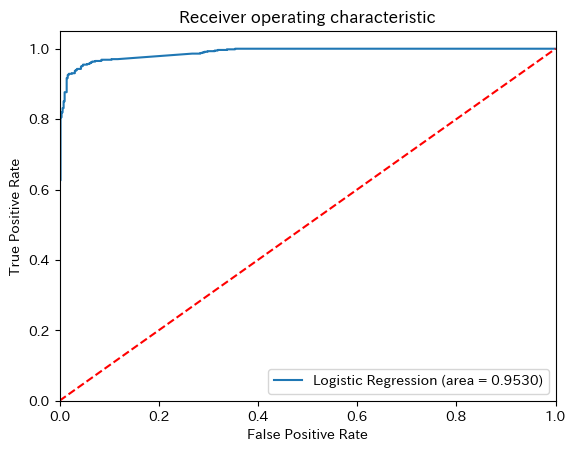

In [115]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### 2. Naive Bayse (Support Vector Machines)

In [116]:
from sklearn.naive_bayes import BernoulliNB
nb = BernoulliNB().fit(X_train, y_train)
y_pred = nb.predict(X_test)

#### Modelの精度

In [117]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=cat.categories))

              precision    recall  f1-score   support

   AbeShinzo       0.92      0.96      0.94       486
hashimoto_lo       0.97      0.93      0.95       575

    accuracy                           0.94      1061
   macro avg       0.94      0.95      0.94      1061
weighted avg       0.95      0.94      0.94      1061



#### Confusion Matirx

In [118]:
print(metrics.confusion_matrix(y_test, y_pred))

[[467  19]
 [ 40 535]]


In [119]:
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), columns = cat.categories,
             index = cat.categories)

AbeShinzo  hashimoto_lo
AbeShinzo           467            19
hashimoto_lo         40           535

#### ROC Curve

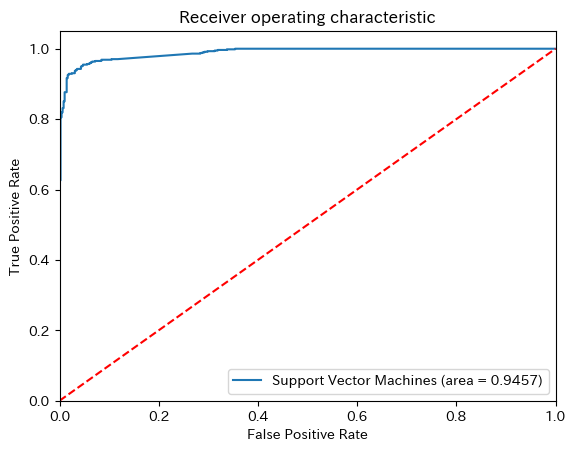

In [120]:

logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Support Vector Machines (area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### 3. SVM (Support Vector Machines)

In [121]:
svm = svm.SVC(random_state=0).fit(X_train, y_train)
y_pred = svm.predict(X_test)

#### Modelの精度

In [122]:
print(classification_report(y_test, y_pred, target_names=cat.categories))

              precision    recall  f1-score   support

   AbeShinzo       0.91      0.96      0.94       486
hashimoto_lo       0.97      0.92      0.94       575

    accuracy                           0.94      1061
   macro avg       0.94      0.94      0.94      1061
weighted avg       0.94      0.94      0.94      1061



#### Confusion Matirx

In [123]:
print(metrics.confusion_matrix(y_test, y_pred))

[[468  18]
 [ 44 531]]


In [124]:
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), columns = cat.categories,
             index = cat.categories)

AbeShinzo  hashimoto_lo
AbeShinzo           468            18
hashimoto_lo         44           531

#### ROC Curve

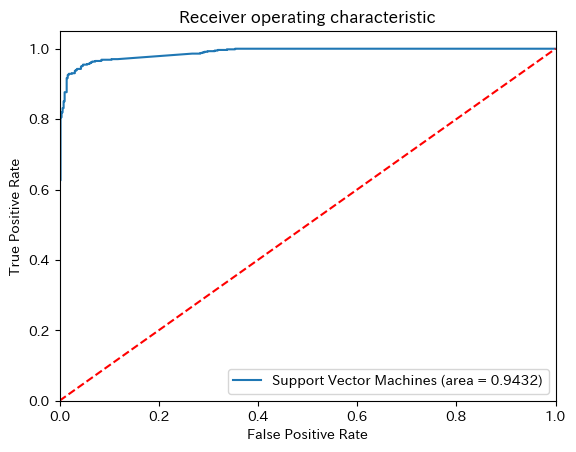

In [125]:

logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Support Vector Machines (area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### 4. Random Forest

In [126]:
rf = RandomForestClassifier(random_state=0).fit(X_train, y_train)
y_pred = rf.predict(X_test)

#### Modelの精度

In [127]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=cat.categories))

              precision    recall  f1-score   support

   AbeShinzo       0.93      0.94      0.93       486
hashimoto_lo       0.95      0.94      0.94       575

    accuracy                           0.94      1061
   macro avg       0.94      0.94      0.94      1061
weighted avg       0.94      0.94      0.94      1061



#### Confusion Matirx

In [128]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))

[[455  31]
 [ 35 540]]


In [129]:
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), columns = cat.categories,
             index = cat.categories)

AbeShinzo  hashimoto_lo
AbeShinzo           455            31
hashimoto_lo         35           540

#### ROC Curve

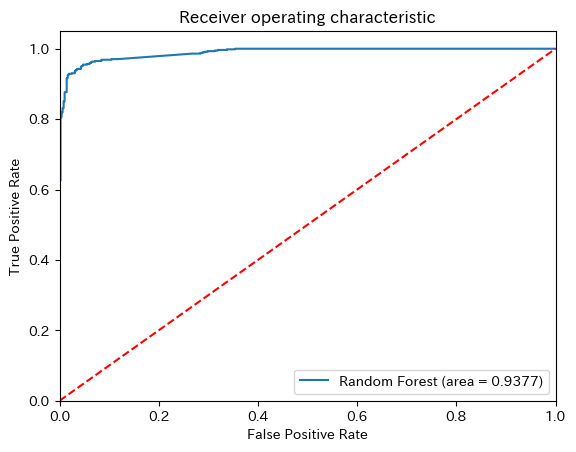

In [130]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### 5. Neural Netowrk

一般的にはsklearnではなくて、TensorflowやKerasを用いて実装することが多いのですが、ここではsklearnで実行します。

In [131]:
nn = MLPClassifier(random_state=0, max_iter=300, hidden_layer_sizes= 50).fit(X_train, y_train)
y_pred = nn.predict(X_test)

#### Modelの精度

In [132]:
print(classification_report(y_test, y_pred, target_names=cat.categories))

              precision    recall  f1-score   support

   AbeShinzo       0.94      0.98      0.96       486
hashimoto_lo       0.98      0.95      0.96       575

    accuracy                           0.96      1061
   macro avg       0.96      0.96      0.96      1061
weighted avg       0.96      0.96      0.96      1061



#### Confusion Matirx

In [133]:
print(metrics.confusion_matrix(y_test, y_pred))

[[474  12]
 [ 30 545]]


In [134]:
pd.DataFrame(metrics.confusion_matrix(y_test, y_pred), columns = cat.categories,
             index = cat.categories)

AbeShinzo  hashimoto_lo
AbeShinzo           474            12
hashimoto_lo         30           545

#### ROC Curve

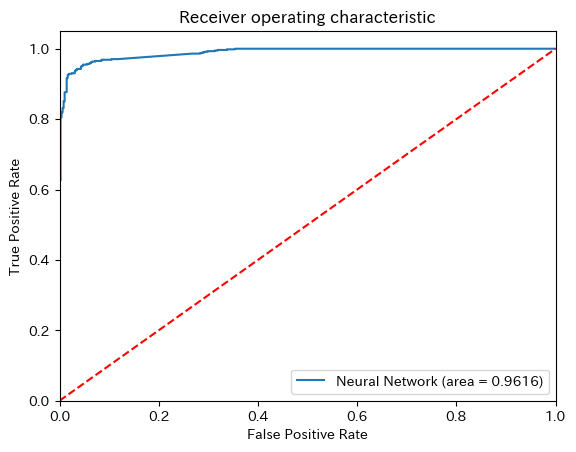

In [135]:

logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Neural Network (area = %0.4f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## PCAによる次元圧縮

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [137]:
X_train.shape

(3183, 690)

In [138]:
# 標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# 平均と分散を計算
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

In [139]:
pca = PCA(n_components=300)
pca.fit(X)
Xpca = pca.transform(X)
X_train = pca.transform(X_train_s)
X_test = pca.transform(X_test_s)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


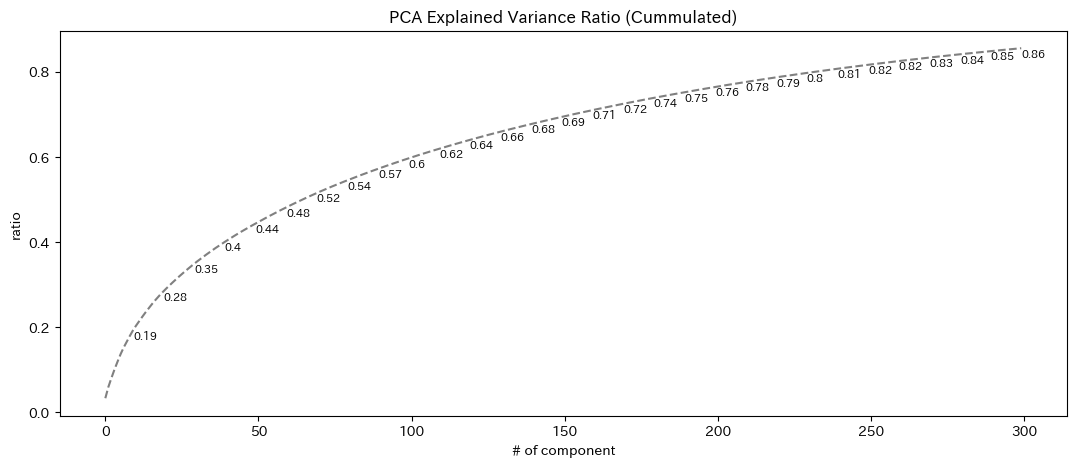

In [140]:
plt.figure(figsize=(13,5))
plt.plot(pca.explained_variance_ratio_.cumsum(),'--', color = 'grey')
for i, ratio in enumerate(pca.explained_variance_ratio_.cumsum()):
    if (i+1) % 10 ==0:
        plt.text(i, ratio-0.02, round(ratio,2), fontsize=8)
plt.title('PCA Explained Variance Ratio (Cummulated)')
plt.xlabel('# of component')
plt.ylabel('ratio')
plt.show()

/var/folders/z5/0lnyp_m54dqc1xkz22ncbj2h0000gn/T/ipykernel_44838/2017848199.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('PiYG', 2))


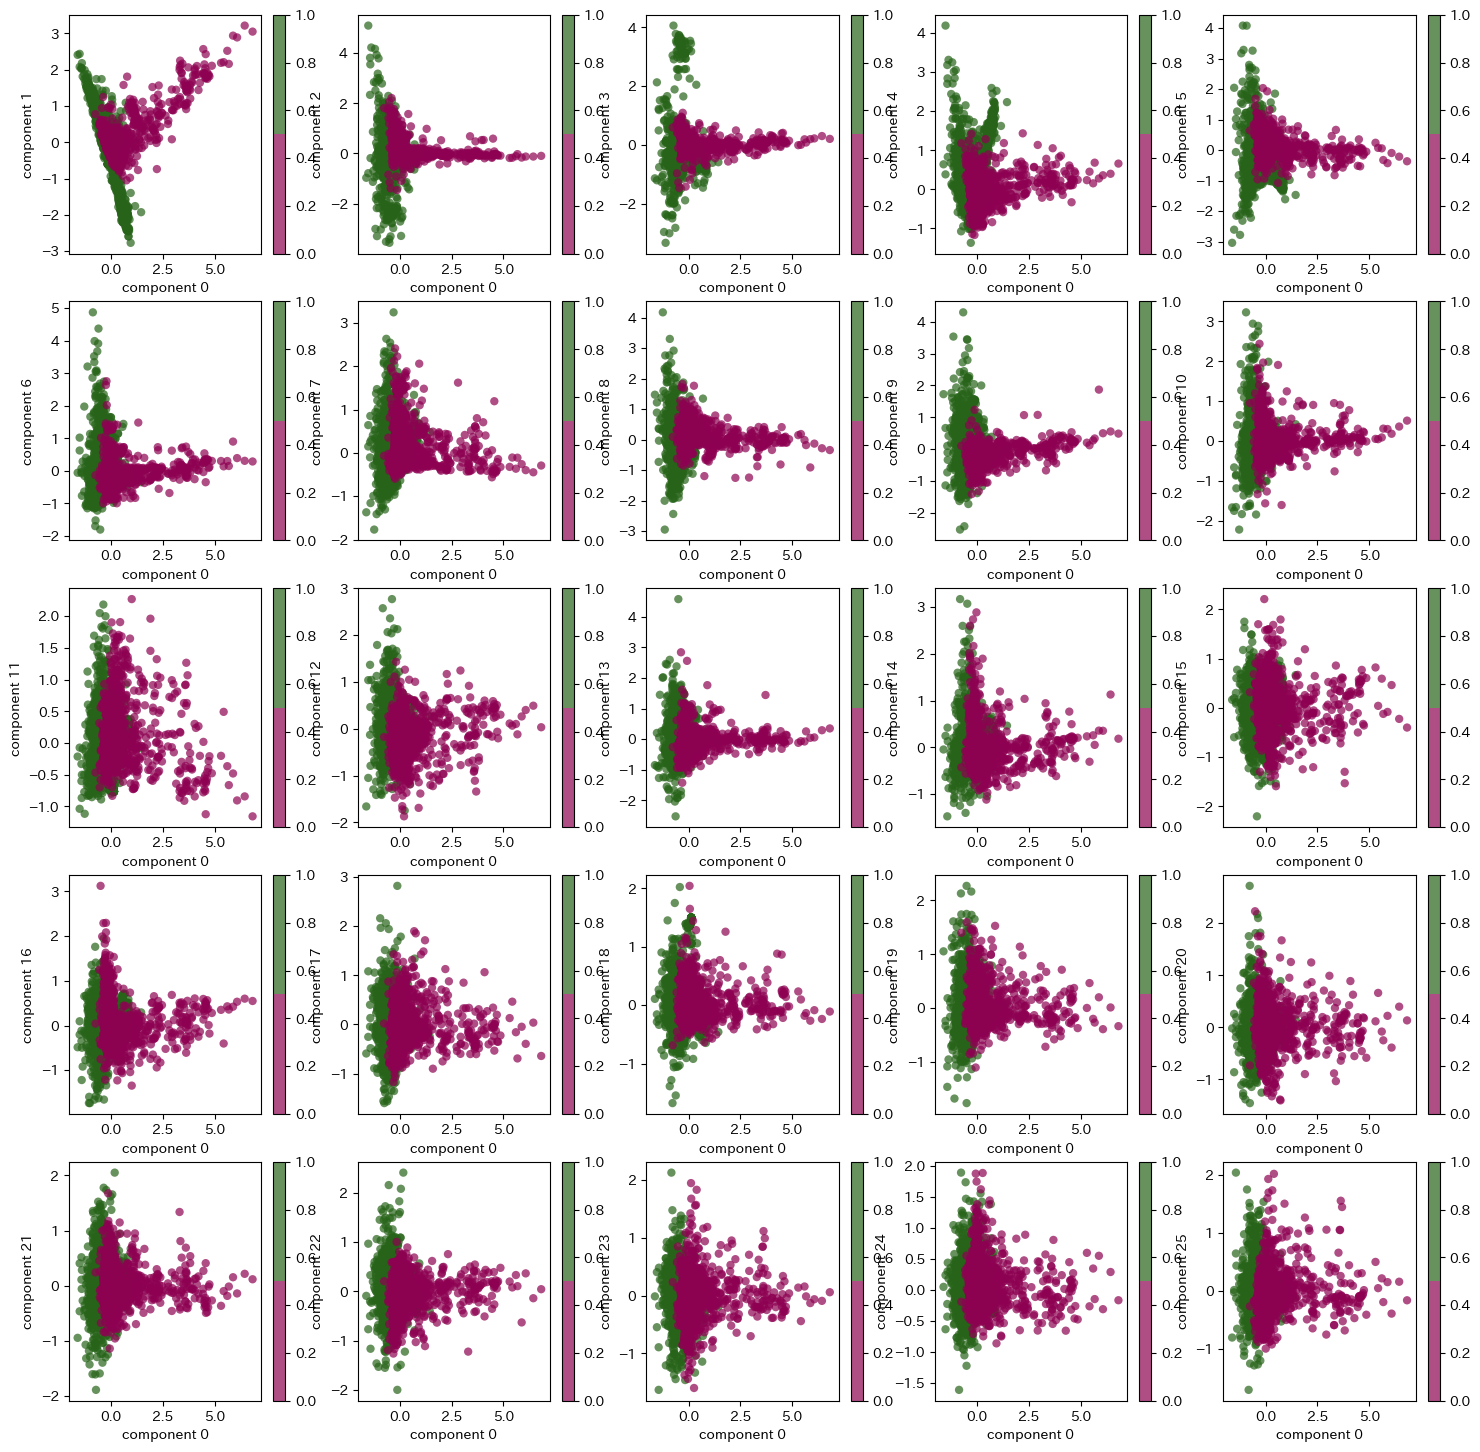

In [141]:
fig, ax = plt.subplots(5,5, figsize = (18,18))
for i, combination in enumerate(list(itertools.combinations(range(len(pca.components_)), 2))[:25]):
    c = i // 5
    i = i - 5*c
    s1 = ax[c, i].scatter(Xpca[:, combination[0]], Xpca[:, combination[1]],
                c=cat.codes, 
                edgecolor='none', alpha=0.7,
                cmap=plt.cm.get_cmap('PiYG', 2))
    ax[c, i].set_xlabel('component {}'.format(combination[0]))
    ax[c, i].set_ylabel('component {}'.format(combination[1]))
    plt.colorbar(s1, ax = ax[c, i])
plt.show()

In [142]:
# logistic regression
lg = LogisticRegression(random_state=0).fit(X_train, y_train)
lg_y_pred = lg.predict(X_test)
# Naive Bayse
nb = BernoulliNB().fit(X_train, y_train)
nb_y_pred = nb.predict(X_test)
# Random Forest
rf = RandomForestClassifier(random_state=0).fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)
# Neural Network
nf = MLPClassifier(random_state=0).fit(X_train, y_train)
nf_y_pred = nf.predict(X_test)

In [143]:
print(metrics.accuracy_score(y_test, lg_y_pred))
print(metrics.accuracy_score(y_test, nb_y_pred))
print(metrics.accuracy_score(y_test, rf_y_pred))
print(metrics.accuracy_score(y_test, nf_y_pred))

0.9349670122525919
0.7709707822808671
0.9302544769085768
0.946277097078228


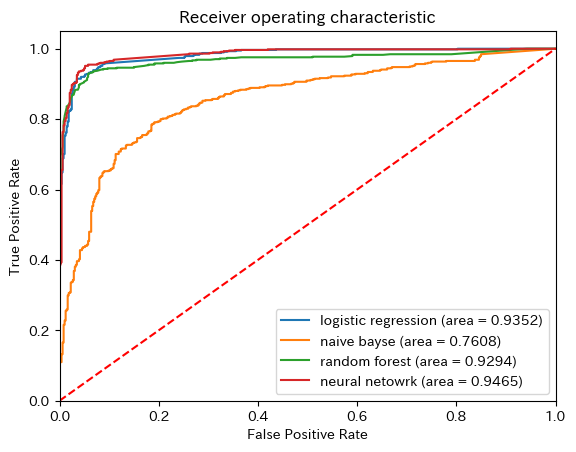

In [144]:
plt.figure()
names = ['logistic regression','naive bayse', 'random forest', 'neural netowrk']
for i, tmp in enumerate(zip([lg_y_pred, nb_y_pred, rf_y_pred, nf_y_pred],[lg,nb,rf,nf])):
    roc_auc = roc_auc_score(y_test, tmp[0])
    fpr, tpr, thresholds = roc_curve(y_test, tmp[1].predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label='{} (area = {})'.format(names[i], round(roc_auc, 4)))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## どのようなトピックがあるか単語共起ネットワークを描く

In [145]:
import networkx as nx

アカウントごとに、単語の共起関係を示す共起行列を作ります

In [146]:
df_hashimoto = df[df['user_screen_name']=='hashimoto_lo']
df_abe = df[df['user_screen_name']=='AbeShinzo']

In [147]:
count_model = CountVectorizer(analyzer=tokenize, ngram_range=(1,1), min_df=0.03, max_df=.95) 
X_a = count_model.fit_transform(df_abe['standarized_text'])
X_a[X_a > 0] = 1 
Xc_a = (X_a.T * X_a)
Xc_a.setdiag(0) 
wordword_a = pd.DataFrame(Xc_a.todense(), index = count_model.get_feature_names_out(),columns = count_model.get_feature_names_out())
wordword_a.shape

(74, 74)

In [148]:
# `min_df`で指定した値より少ない出現回数の単語は除外します。
# `max_df`で指定した値より多い出現回数の単語は除外します。[0, 1]の間の値で割合での指定もできます。
count_model = CountVectorizer(analyzer=tokenize, ngram_range=(1,1), min_df=0.04, max_df=.95) 
X_h = count_model.fit_transform(df_hashimoto['standarized_text'])
X_h[X_h > 0] = 1 
Xc_h = (X_h.T * X_h)
Xc_h.setdiag(0) 
wordword_h = pd.DataFrame(Xc_h.todense(), index = count_model.get_feature_names_out(),columns = count_model.get_feature_names_out())
wordword_h.shape

(69, 69)

In [149]:
# create network
G_h = nx.from_pandas_adjacency(wordword_h)
G_a = nx.from_pandas_adjacency(wordword_a)

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 10145 (\N{BLACK RIGHTWARDS ARROW}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


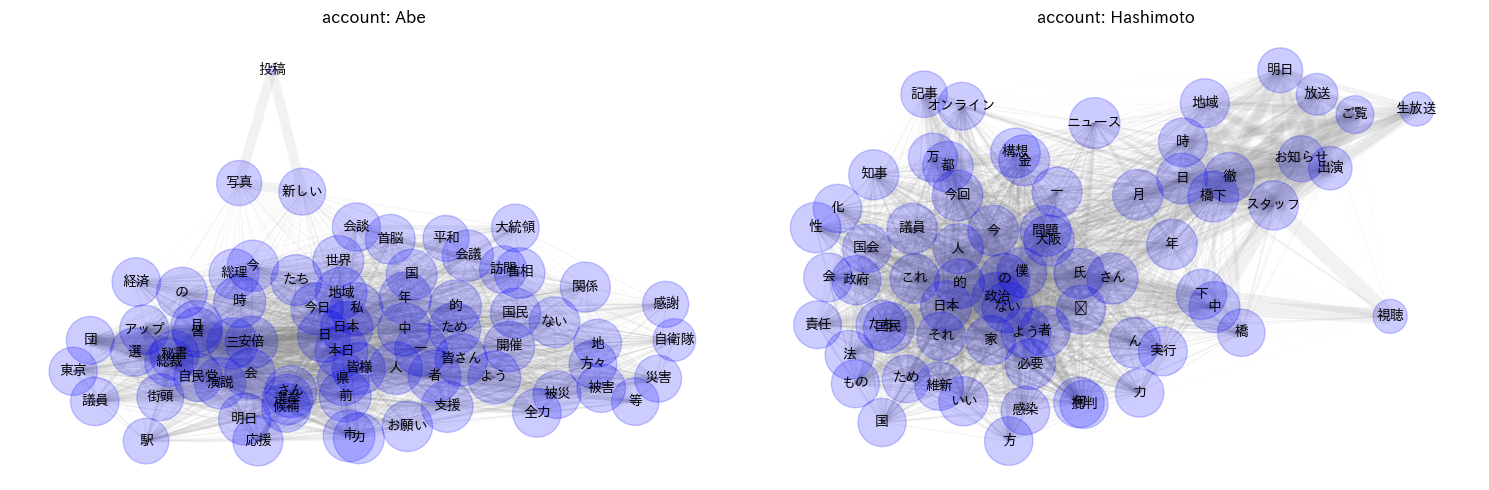

In [150]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i in range(2):
    ax = axs[i]
    G = [G_a, G_h][i]
    # Position nodes using Fruchterman-Reingold force-directed algorithm.
    # https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
    pos = nx.spring_layout(G, seed=999)
    d = dict(G.degree)
    weights = [G[u][v]['weight']*0.1 for u,v in G.edges()]
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='blue', node_size=[v * 20 for v in d.values()], alpha = 0.2)
    nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.1, width=list(weights), edge_color = 'grey')
    nx.draw_networkx_labels(G, pos, ax=ax, font_family='IPAexGothic', font_size=10)
    ax.set_title('account: {}'.format(['Abe', 'Hashimoto'][i]))
    ax.axis('off')
plt.tight_layout()
plt.show()

Abe


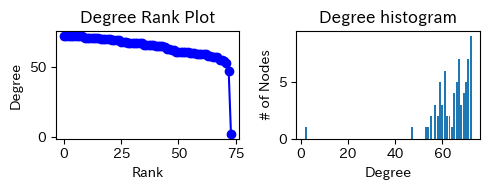

Hashimoto


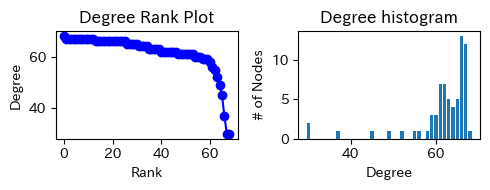

In [151]:
for c, G in enumerate([G_a, G_h]):
    print(['Abe','Hashimoto'][c])
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)
    fig, axs = plt.subplots(1, 2, figsize=(5, 2))
    ax = axs[0]
    ax.plot(degree_sequence, "b-", marker="o")
    ax.set_title("Degree Rank Plot")
    ax.set_ylabel("Degree")
    ax.set_xlabel("Rank")

    ax = axs[1]
    ax.bar(*np.unique(degree_sequence, return_counts=True))
    ax.set_title("Degree histogram")
    ax.set_xlabel("Degree")
    ax.set_ylabel("# of Nodes")
    plt.tight_layout()
    plt.show()